# DPI bioactivity 

In [263]:
import pandas as pd
import mysql.connector
import seaborn as sns 
import matplotlib.pyplot as plt

conn = mysql.connector.connect(
    host='localhost',       
    user='tim',
    password="Neuroblastoma",
    database='chembl_36'
)

In [264]:
query ="""
SELECT
	 act.pchembl_value,
     act.standard_value,
     act.activity_comment,
     assays.description,
     tar.pref_name,
     tar.target_type
FROM activities as act
JOIN assays
	ON act.assay_id = assays.assay_id
JOIN target_dictionary AS tar
	ON tar.tid=assays.tid 
WHERE 
	act.molregno IN (322987, 391098, 2270359)
;
"""

dpi_data = pd.read_sql(query, conn,)

C:\Users\Tim\AppData\Local\Temp\ipykernel_10576\3578058303.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dpi_data = pd.read_sql(query, conn,)


In [265]:
validvals=dpi_data.dropna(subset="pchembl_value")

In [266]:
data= validvals.pivot_table(
        columns="target_type",
        values="pchembl_value",
        index="pref_name"
            ).drop("UNCHECKED",axis=1)

In [267]:
data= validvals.pivot_table(
        columns="target_type",
        values="pchembl_value",
        index="pref_name",
        aggfunc="max"
            ).drop(["UNCHECKED","NON-MOLECULAR","protein-protein interaction".upper()],axis=1).drop(["Unchecked","NON-PROTEIN TARGET","Rattus norvegicus","Homo sapiens"])#.sort_values(by="single protein")

In [268]:
data.columns = [col.lower() for col in data.columns]

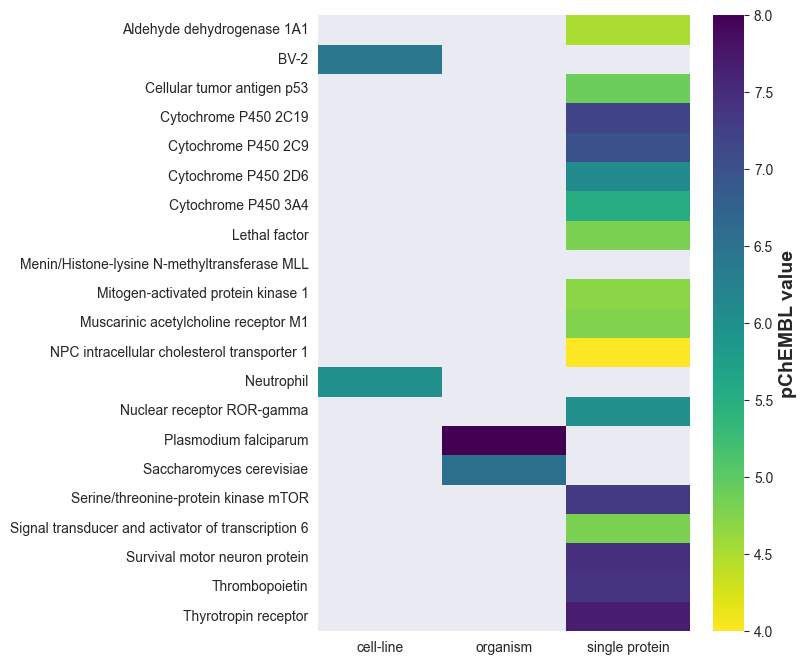

In [269]:
sns.set_style("dark")
plt.figure(figsize=(6,8))

ax= sns.heatmap(
    data=data,    
    vmin=4,vmax=8,
    cmap="viridis_r"
)
cb = ax.collections[0].colorbar
cb.set_label("pChEMBL value",fontsize=14,fontweight="bold")

plt.xticks(rotation=0) 
plt.ylabel(None) 

plt.savefig("DPI_activity.svg")

In [272]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.molSize = 300,300

C:\Users\Tim\AppData\Local\Temp\ipykernel_10576\1112870406.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dpi_structure = pd.read_sql(query, conn,)


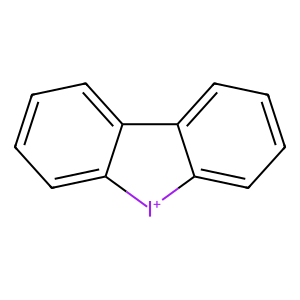

In [273]:
query="""
SELECT * 
FROM compound_structures
WHERE molregno LIKE 322987
;
"""

dpi_structure = pd.read_sql(query, conn,)
smile=dpi_structure["canonical_smiles"].values[0]

# create molecule object and draw it.
mol = Chem.MolFromSmiles(smile)
img = Draw.MolToImage(mol, size=(300, 300))
img

In [274]:
drawer = Draw.MolDraw2DSVG(300, 300)
Draw.rdMolDraw2D.PrepareAndDrawMolecule(drawer, mol)
drawer.FinishDrawing()

svg = drawer.GetDrawingText()
with open("dpi.svg", "w") as f:
    f.write(svg)